In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

#XGBoost uygulayacağım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")

In [ ]:
#Tahmin etmek istediğim hedef sütunlar
target_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# X ve y'yi ayırıp, eksik verileri atıyorum.
df = df.dropna(subset=target_columns)
X = df.drop(columns=target_columns)
y = df[target_columns]

#Kategorik ve sayısal sütunlar olarak ayırım
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()


In [ ]:
#Ön işleme pipeline (sayısal + kategorik özellikler)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

#XGBoost algoritmasını pipeline'a ekliyorum
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=42, verbosity=0)))
])

#Eğitim/test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Model eğitimi
pipeline.fit(X_train, y_train)

#Tahmin
y_pred = pipeline.predict(X_test)


In [ ]:
#İlk gözlem için gerçek ve tahmin edilen değerlerin karşılaştırması
rows = []

i = 0  #İlk satır

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Sonuçların bir DataFrame olarak gösterilmesi
comparison_df = pd.DataFrame(rows)

#Sayıları daha okunabilir yapmak için float formatına ayarladım.
pd.options.display.float_format = '{:,.2f}'.format

print("Gerçek vs Tahmin Değerleri (İlk gözlem):")
print(comparison_df)


Gerçek vs Tahmin Değerleri (İlk gözlem):
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs  1,261,651.00   1,306,941.38
1      copyDuration      1,257.00       1,275.12
2   durationInQueue      1,230.00       1,222.87
3     queueDuration      1,229.00       1,225.42
4  transferDuration         20.00          30.90
5     totalDuration      1,257.00       1,275.59
6        throughput        391.25         675.55


In [ ]:
#Performans metriklerini her hedef sütun için yazdırıyorum.
print("Her Süre Sütunu İçin XGBoost Performans Skorları:\n")

for i, col in enumerate(y.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]  # XGB tahminleri

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}")
    print(f"  MAE   : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE  : {round(rmse, 2)}")
    print(f"  R²    : {round(r2, 4)}\n")


Her Süre Sütunu İçin XGBoost Performans Skorları:

durationInMs:
  MSE   : 116787372032.0
  MAE   : 143130.0
  MAE (%) : 29.73%
  RMSE  : 341741.67
  R²    : 0.4924

copyDuration:
  MSE   : 3845.23
  MAE   : 11.08
  MAE (%) : 2.02%
  RMSE  : 62.01
  R²    : 0.9839

durationInQueue:
  MSE   : 43.77
  MAE   : 3.5
  MAE (%) : 0.7%
  RMSE  : 6.62
  R²    : 0.9998

queueDuration:
  MSE   : 21.68
  MAE   : 2.85
  MAE (%) : 0.57%
  RMSE  : 4.66
  R²    : 0.9999

transferDuration:
  MSE   : 500.55
  MAE   : 6.53
  MAE (%) : 19.22%
  RMSE  : 22.37
  R²    : 0.9594

totalDuration:
  MSE   : 4233.02
  MAE   : 11.68
  MAE (%) : 2.13%
  RMSE  : 65.06
  R²    : 0.9823

throughput:
  MSE   : 29459.38
  MAE   : 35.34
  MAE (%) : 41.57%
  RMSE  : 171.64
  R²    : 0.756



In [ ]:
#Ön işleme sonrası sütun isimlerini alma fonksiyonu
def get_feature_names(preprocessor):
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    num_features = numerical_features
    return list(cat_features) + list(num_features)

#Ön işleme sonrası tüm özellik isimlerini aldım.
feature_names = get_feature_names(preprocessor)
total_features = set(feature_names)

# Dönüştürülmüş veri
X_train_transformed = preprocessor.transform(X_train)

# Sparse ise dense yapıyorum.
if hasattr(X_train_transformed, "toarray"):
    X_train_dense = X_train_transformed.toarray()
else:
    X_train_dense = X_train_transformed

#Özellik sayısı ve dönüşmüş verinin boyutunu kontrol ediyorum.
print("Feature name count:", len(feature_names)) # Kaç tane özellik olduğunu yazdırır. (4480 o yüzden 2240 özellik seçiyorum.)
print("X_train_dense shape:", X_train_dense.shape) # Dönüştürülmüş verinin satır x sütun boyutunu yazdırır.

for target in target_columns:
    print(f"\n Hedef: {target} için")

    # XGBoost modelini tanımlıyorum.
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # RFE (Recursive Feature Elimination) ile en iyi 2240 özelliği seçiyorum.
    rfe_selector = RFE(estimator=xgb_model, n_features_to_select=2240, step=100)
    rfe_selector.fit(X_train_dense, y_train[target])

    # RFE'de seçilmeyen özellikler (en az önemli 2240'ını seçmek için)
    rfe_not_selected = [feature_names[i] for i, selected in enumerate(rfe_selector.support_) if not selected]

    # SHAP (SHapley Additive exPlanations) ile özellik önemlerini hesaplamak için explainer oluşturulması
    xgb_model.fit(X_train_dense, y_train[target])
    explainer = shap.Explainer(xgb_model, X_train_dense, feature_names=feature_names)
    shap_values = explainer(X_train_dense)
    shap_importance = np.abs(shap_values.values).mean(axis=0)

    # SHAP önemlerine göre en az önemli 2240 özellik
    shap_sorted_indices = np.argsort(shap_importance)
    shap_least_2240 = [feature_names[i] for i in shap_sorted_indices[:2240]]

    # RFE ve SHAP en az önemli 2240'ın kesişimi
    common_low_impact = set(rfe_not_selected).intersection(set(shap_least_2240))

    #Uzun feature isimlerinden sadece ana sütun isimlerini çıkarıp tekrarları kaldırıyorum.
    def get_short_names(long_names):
        return sorted(set([name.split('_')[0] for name in long_names]))

    short_common_low_impact = get_short_names(common_low_impact)

    print(f"RFE ve SHAP'a göre en az önemli özelliklerin kesişiminden benzersiz sütun isimleri:")
    print(short_common_low_impact)

#shap ve rfe ile en az önemli olan sütunların kesişimini yazdırıyorum ki modeli optimize edebileyim.


Feature name count: 4480
X_train_dense shape: (942, 4480)

 Hedef: durationInMs için
RFE ve SHAP'a göre en az önemli özelliklerin kesişiminden benzersiz sütun isimleri:
['activityRunId', 'activityRunStart', 'activityType', 'pipelineName', 'pipelineRunId']

 Hedef: copyDuration için
RFE ve SHAP'a göre en az önemli özelliklerin kesişiminden benzersiz sütun isimleri:
['activityRunId', 'activityRunStart', 'activityType', 'pipelineName', 'pipelineRunId']

 Hedef: durationInQueue için
RFE ve SHAP'a göre en az önemli özelliklerin kesişiminden benzersiz sütun isimleri:
['activityRunId', 'activityRunStart', 'activityType', 'pipelineName']

 Hedef: queueDuration için
RFE ve SHAP'a göre en az önemli özelliklerin kesişiminden benzersiz sütun isimleri:
['activityRunId', 'activityRunStart', 'activityType', 'pipelineName']

 Hedef: transferDuration için
RFE ve SHAP'a göre en az önemli özelliklerin kesişiminden benzersiz sütun isimleri:
['activityRunId', 'activityRunStart', 'activityType', 'pipelineNa

In [ ]:
#Shap ve rfe sonucu etkisiz özelliklerin çıkarımını yaptım.
cols_to_remove = [
    'activityRunId', 'activityRunStart', 'activityType', 'pipelineName', 'pipelineRunId'
]

X = X.drop(columns=[col for col in cols_to_remove if col in X.columns])
categorical_features = [col for col in categorical_features if col not in cols_to_remove]
numerical_features = [col for col in numerical_features if col not in cols_to_remove]

target_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# Eksik değerleri atımı
df = df.dropna(subset=target_columns)

#X ve y'yi ayır
X = df.drop(columns=target_columns)
y = df[target_columns]

# Eğitim/test bölmesi
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#Eğer y_train tek sütun olursa diye DataFrame'e çevirdim.
y_train = y_train if isinstance(y_train, pd.DataFrame) else y_train.to_frame()
y_test = y_test if isinstance(y_test, pd.DataFrame) else y_test.to_frame()


In [ ]:
#Ön işleme
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

#XGBoost multioutput modeli
base_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', base_model)
])

#Parametre aralığı, MultiOutputRegressor altında tek model parametreleri için:
param_dist = {
    'regressor__estimator__n_estimators': [50, 100, 150, 200],
    'regressor__estimator__max_depth': [4, 6, 8, 10],
    'regressor__estimator__learning_rate': [0.01, 0.05, 0.1],
    'regressor__estimator__subsample': [0.6, 0.8, 1],
    'regressor__estimator__colsample_bytree': [0.6, 0.8, 1]
}

#RandomizedSearchCV ile model optimizasyonu
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    error_score='raise'
)

random_search.fit(X_train, y_train)

print("En iyi parametreler:", random_search.best_params_)
print(f"En iyi R² skoru: {random_search.best_score_:.4f}")

#RandomizedSearchCV ile en iyi parametrelere erişip modelin tahminini iyileştirmek istiyorum.

Fitting 3 folds for each of 15 candidates, totalling 45 fits
En iyi parametreler: {'regressor__estimator__subsample': 0.8, 'regressor__estimator__n_estimators': 150, 'regressor__estimator__max_depth': 4, 'regressor__estimator__learning_rate': 0.05, 'regressor__estimator__colsample_bytree': 0.8}
En iyi R² skoru: 0.8956


In [ ]:
#En iyi parametreleri buraya koyuyorum
best_params = {
    'subsample': 0.8,
    'n_estimators': 150,
    'max_depth': 4,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8
}

#Modeli oluşturuyorum
xgb = XGBRegressor(
    subsample=best_params['subsample'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    objective='reg:squarederror',
    verbosity=0
)

multi_xgb = MultiOutputRegressor(xgb)

#Pipeline oluşturuyorum
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', multi_xgb)
])

#Model eğitimi
pipeline.fit(X_train, y_train)

#Tahmin
y_pred = pipeline.predict(X_test)

# Yeni parametrelere göre performans metriklerini hesaplıyorum.
print("Her Süre Sütunu İçin Performans Skorları:\n")

for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}")
    print(f"  MAE   : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE  : {round(rmse, 2)}")
    print(f"  R²    : {round(r2, 4)}\n")

#RandomizedSearchCV ile bulduğum en iyi parametreleri bu kısımda yerine koyuyorum ve metrikleri iyileştiriyorum.

Her Süre Sütunu İçin Performans Skorları:

durationInMs:
  MSE   : 91321597952.0
  MAE   : 141786.88
  MAE (%) : 29.46%
  RMSE  : 302194.64
  R²    : 0.6031

copyDuration:
  MSE   : 4517.85
  MAE   : 16.85
  MAE (%) : 3.08%
  RMSE  : 67.21
  R²    : 0.9811

durationInQueue:
  MSE   : 203.35
  MAE   : 6.91
  MAE (%) : 1.38%
  RMSE  : 14.26
  R²    : 0.999

queueDuration:
  MSE   : 205.94
  MAE   : 7.05
  MAE (%) : 1.4%
  RMSE  : 14.35
  R²    : 0.999

transferDuration:
  MSE   : 749.06
  MAE   : 8.13
  MAE (%) : 23.95%
  RMSE  : 27.37
  R²    : 0.9393

totalDuration:
  MSE   : 4804.52
  MAE   : 16.06
  MAE (%) : 2.93%
  RMSE  : 69.31
  R²    : 0.9799

throughput:
  MSE   : 28443.33
  MAE   : 38.03
  MAE (%) : 44.74%
  RMSE  : 168.65
  R²    : 0.7644



In [ ]:
#İlk gözlem için gerçek ve tahmin edilen değerlerin karşılaştırması
rows = []

i = 0  #İlk satır

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Sonuçların bir DataFrame olarak gösterilmesi
comparison_df = pd.DataFrame(rows)

#Sayıları daha okunabilir yapmak için float formatına ayarladım.
pd.options.display.float_format = '{:,.2f}'.format

print("Gerçek vs Tahmin Değerleri (İlk gözlem):")
print(comparison_df)


Gerçek vs Tahmin Değerleri (İlk gözlem):
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs  1,261,651.00   1,167,672.88
1      copyDuration      1,257.00       1,154.16
2   durationInQueue      1,230.00       1,105.58
3     queueDuration      1,229.00       1,113.16
4  transferDuration         20.00          22.70
5     totalDuration      1,257.00       1,152.43
6        throughput        391.25         644.66


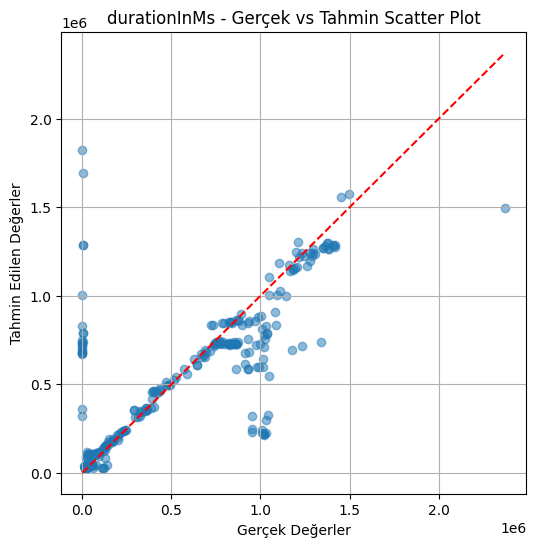

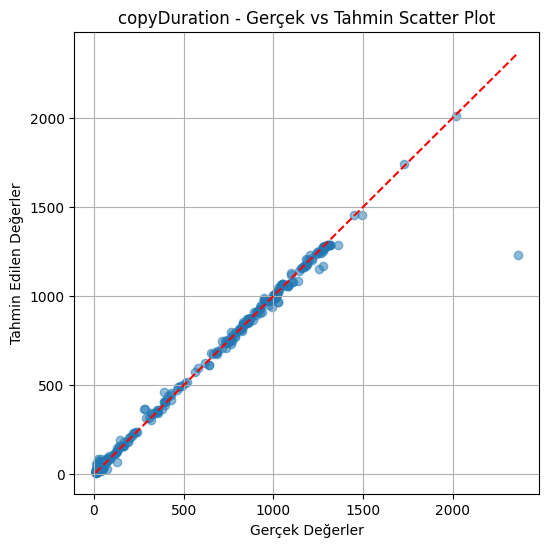

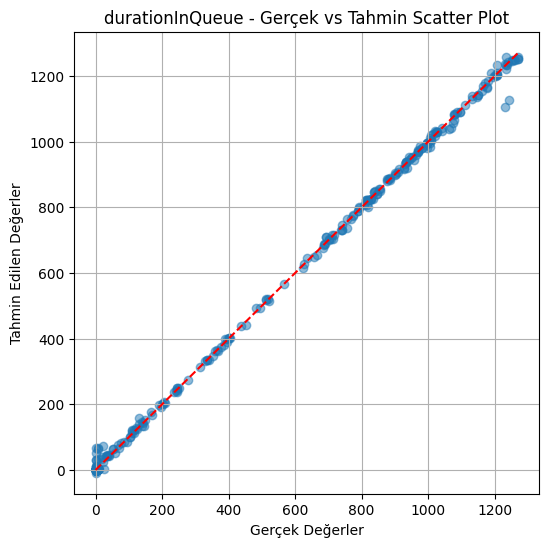

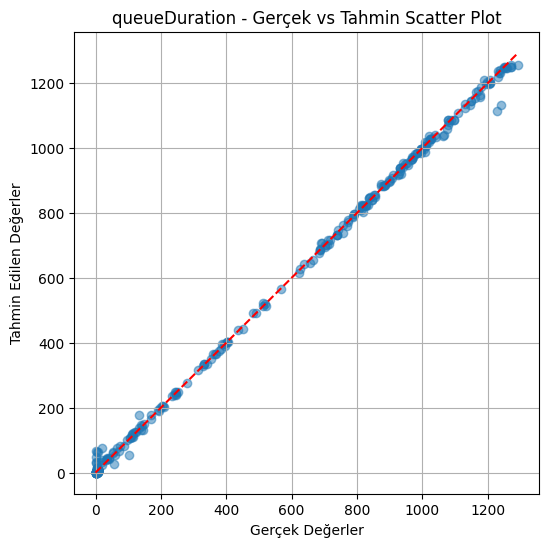

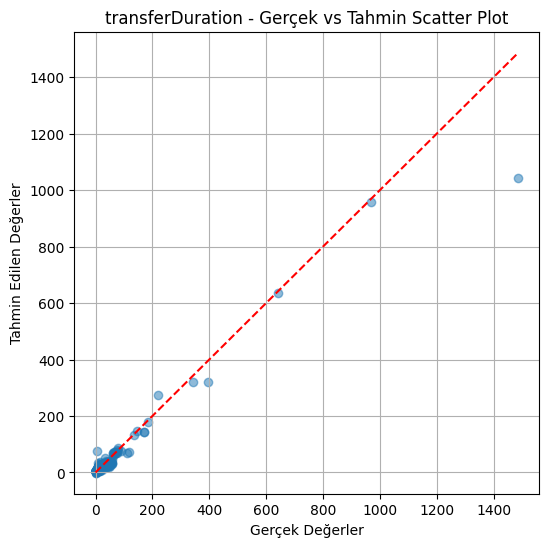

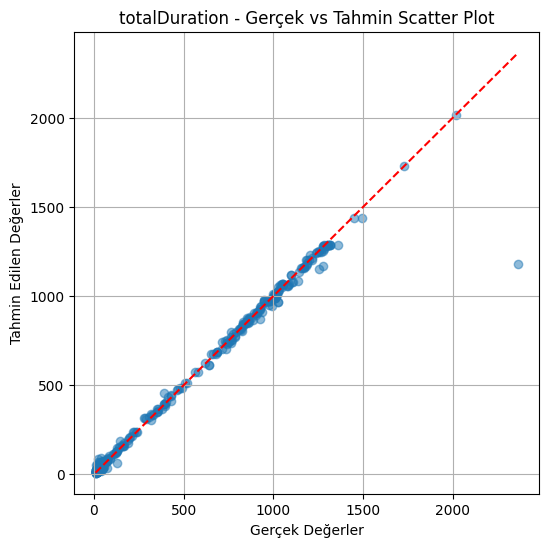

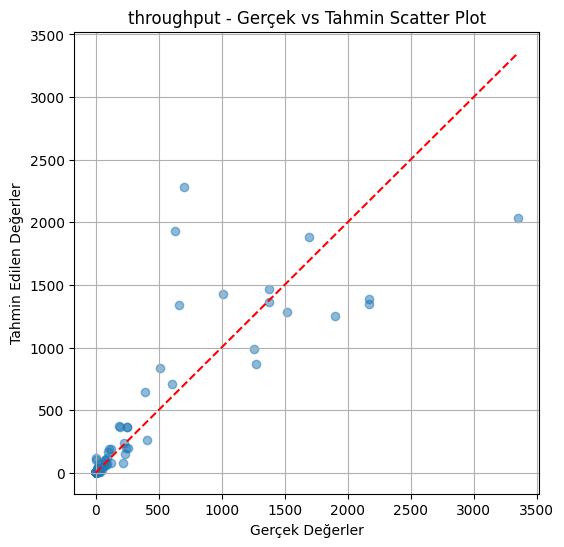

In [ ]:
#Tahminlerin gerçeğe ne kadar yakınlaştığını görmek adına her hedef sütun için scatter plot oluşturuyorum.
for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred_col, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--') # 45 derece referans çizgisi
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Edilen Değerler')
    plt.title(f'{col} - Gerçek vs Tahmin Scatter Plot')
    plt.grid(True)
    plt.show()
